<!--NAVIGATION-->
< [深入：支持向量机](05.07-Support-Vector-Machines.ipynb) | [目录](Index.ipynb) | [深入：主成分分析](05.09-Principal-Component-Analysis.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.08-Random-Forests.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: Decision Trees and Random Forests

# 深入：決策樹和隨機森林

> Previously we have looked in depth at a simple generative classifier (naive Bayes; see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) and a powerful discriminative classifier (support vector machines; see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we'll take a look at motivating another powerful algorithm—a non-parametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning that it relies on aggregating the results of an ensemble of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting!

前面我們深入的介紹了簡單的生成分類器（樸素貝葉斯）和強大的決定分類器（支持向量機）。另外一種強大的算法，一個沒有參數被稱為*隨機森林*的算法。隨機森林是一個集成的方法，這意味著它是是在一系列簡單評估器組合的基礎上建立的。令人驚奇的是，這種組合的方法會比獨立的算法應用要強大：即通過多個評估器得到的多數票選舉結果要優於其中任何一個獨立的評估器得到的結果。

## Motivating Random Forests: Decision Trees

## 開始學習隨機森林：決策樹

> Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

決策樹是用來分類或者標記對象的非常直觀的方法：你只需要簡單的提出一系列設計好的問題，最終達到分類標籤即可。例如，如果希望構建一個用來分類動物的決策樹，你可以構建下面的這棵樹：

![](figures/05.08-decision-tree.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Example)

> The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

這種二元的區分方式使得算法非常高效：在一個構造良好的樹中，每個問題都會使得剩下的可用選項減半，這甚至在分類數量很多情況下也能迅速的得到結果。當然這個效率取決於每一步設計問題的技巧。在決策樹的機器學習實現中，樹中的問題通常都採用沿著軸來分割數據：也就是說，樹中的每個節點會在數據的一個特徵上，根據一個閾值一分為二。

### Creating a decision tree 創建決策樹

> Consider the following two-dimensional data, which has one of four class labels:

考慮下面的二維數據，具有四個分類標籤：

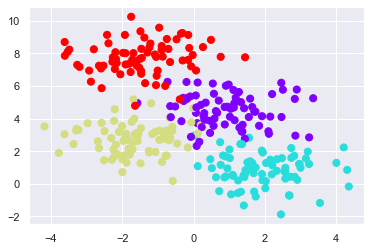

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

> A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

在這個數據上建立的簡單決策樹會沿著兩個軸來分類數據，每一層的劃分都會按照區域中大多數數據點的分類標籤（多數票）來確定區域的標籤值。下面的圖像展示了頭四層的決策樹進行分類的可視化過程：

![](figures/05.08-decision-tree-levels.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

> Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

上圖看到第一層分類後，圖中上部的分支一直保持不變，因此沒有必要再對這個分支進行細分了。除非某個節點已經達到包含同一顏色的目的，否則每一層的不同區域都是再次沿著兩個特徵其中之一對數據進行再次細分。

In [19]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

> Let's write a quick utility function to help us visualize the output of the classifier:

然後我們寫一個工具函數幫助我們展示分類器的數據可視化：

In [20]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # plt
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # result
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

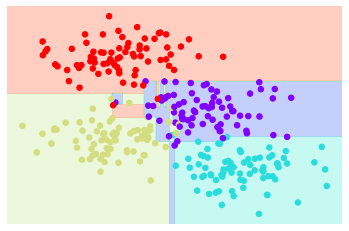

In [21]:
visualize_classifier(DecisionTreeClassifier(), X, y)

> Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

隨著深度（樹節點層次）增加，我們會得到一個非常奇怪的分類區域形狀；如上面深度為5時，圖像下部會出現一條很高的狹長紫色區域，處於綠色和藍色區域之間。從直覺上我們就可以知道這是錯誤的，這個結果不是來源自數據的內在分佈特性，而更像是通過數據中個別的樣本或噪音獲得的。也就是說決策樹即使只有5層深也發生了數據的過擬合。

### Decision trees and over-fitting 決策樹和過擬合

> Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data: It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

這種過擬合是決策樹經常出現的問題：很容易就會構建一個深度太大的決策樹，這樣的樹模型會聚焦在數據的特定數據點或噪音之上，而不是數據本身的分佈特性之上。另外一種判斷過擬合的方法是在數據不同子集上的訓練結果，例如，下面兩張圖表示的是在數據集各一半的數據點上訓練得到的兩個不同的模型：很明顯的看到，在一些位置上，兩棵樹都產生了相同的結果（例如四個角附近的位置），但是在其他位置上，兩個模型給出了非常差異的分類結果（例如在兩個分類的交界處）。這些差異一般會出現在分類器確定性較低的位置，因此如果我們同時使用這兩棵樹的特性的話，可以預計得到更好的結果。

![](figures/05.08-decision-tree-overfitting.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

### Example decision tree

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

data=pd.read_csv("input/Product.csv")
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


In [31]:
X=data.iloc[:,[2,3]].values
Y=data.iloc[:,4].values

In [32]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train,X_test,Y_train,Y_test=train_test_split(X_scaled,Y,test_size=0.2)
model=tree.DecisionTreeClassifier(max_leaf_nodes=10)  #沿著兩個特徵其中之一對數據進行再次細分

[Text(0.5769230769230769, 0.9166666666666666, 'X[0] <= 0.463\ngini = 0.472\nsamples = 320\nvalue = [198, 122]'),
 Text(0.3076923076923077, 0.75, 'X[1] <= 0.595\ngini = 0.294\nsamples = 223\nvalue = [183, 40]'),
 Text(0.15384615384615385, 0.5833333333333334, 'X[0] <= -0.11\ngini = 0.072\nsamples = 186\nvalue = [179, 7]'),
 Text(0.07692307692307693, 0.4166666666666667, 'gini = 0.0\nsamples = 127\nvalue = [127, 0]'),
 Text(0.23076923076923078, 0.4166666666666667, 'X[1] <= 0.404\ngini = 0.209\nsamples = 59\nvalue = [52, 7]'),
 Text(0.15384615384615385, 0.25, 'X[1] <= -0.066\ngini = 0.185\nsamples = 58\nvalue = [52, 6]'),
 Text(0.07692307692307693, 0.08333333333333333, 'gini = 0.0\nsamples = 28\nvalue = [28, 0]'),
 Text(0.23076923076923078, 0.08333333333333333, 'gini = 0.32\nsamples = 30\nvalue = [24, 6]'),
 Text(0.3076923076923077, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.46153846153846156, 0.5833333333333334, 'X[0] <= -1.065\ngini = 0.193\nsamples = 37\nvalue = [4, 33]'),

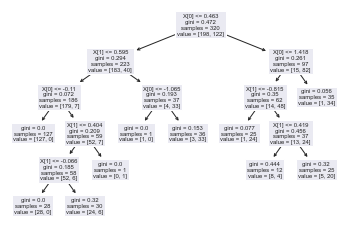

In [33]:
tree.plot_tree(model.fit(X_train,Y_train))

<AxesSubplot:>

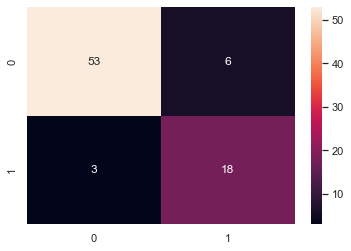

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_predicted=model.predict(X_test)
matrix=confusion_matrix(Y_test,y_predicted)
sns.heatmap(matrix,annot=True)

### Example2 decision tree

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel("input/Churn_Modelling.xlsx")
data = data.drop(["RowNumber" , "CustomerId" , "Surname"] , axis = 1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,608.0,Spain,Female,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,502.0,France,Female,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0
3,699.0,France,Female,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0
4,850.0,Spain,Female,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0


In [44]:
from sklearn.preprocessing import LabelEncoder

d_types = dict(data.dtypes)
for name , type_ in d_types.items():
    if str(type_) == 'object':
        Le = LabelEncoder()
        data[name] = Le.fit_transform(data[name])

In [45]:
from sklearn.model_selection import train_test_split

remaining_columns = list(data.columns)
remaining_columns.remove("Exited")
X = data[remaining_columns].values 
Y = data['Exited'].values.astype(np.uint8)
Xtrain , Xtest , Ytrain , Ytest = train_test_split(X , Y , test_size = 0.2 , random_state = 4)
print("Testing Accuracy : " , model.score(Xtest , Ytest))

[Text(0.5, 0.9, 'Age <= 42.5\ngini = 0.326\nsamples = 8000\nvalue = [6359, 1641]\nclass = 0'),
 Text(0.25, 0.7, 'NumOfProducts <= 2.5\ngini = 0.21\nsamples = 5706\nvalue = [5026, 680]\nclass = 0'),
 Text(0.125, 0.5, 'NumOfProducts <= 1.5\ngini = 0.188\nsamples = 5583\nvalue = [4996, 587]\nclass = 0'),
 Text(0.0625, 0.3, 'Age <= 38.5\ngini = 0.278\nsamples = 2778\nvalue = [2315, 463]\nclass = 0'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'Balance <= 1884.345\ngini = 0.085\nsamples = 2805\nvalue = [2681, 124]\nclass = 0'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'Balance <= 23194.08\ngini = 0.369\nsamples = 123\nvalue = [30, 93]\nclass = 1'),
 Text(0.3125, 0.3, 'EstimatedSalary <= 163880.562\ngini = 0.5\nsamples = 41\nvalue = [21, 20]\nclass = 0'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'EstimatedSalary <= 187454.992\ngini = 0

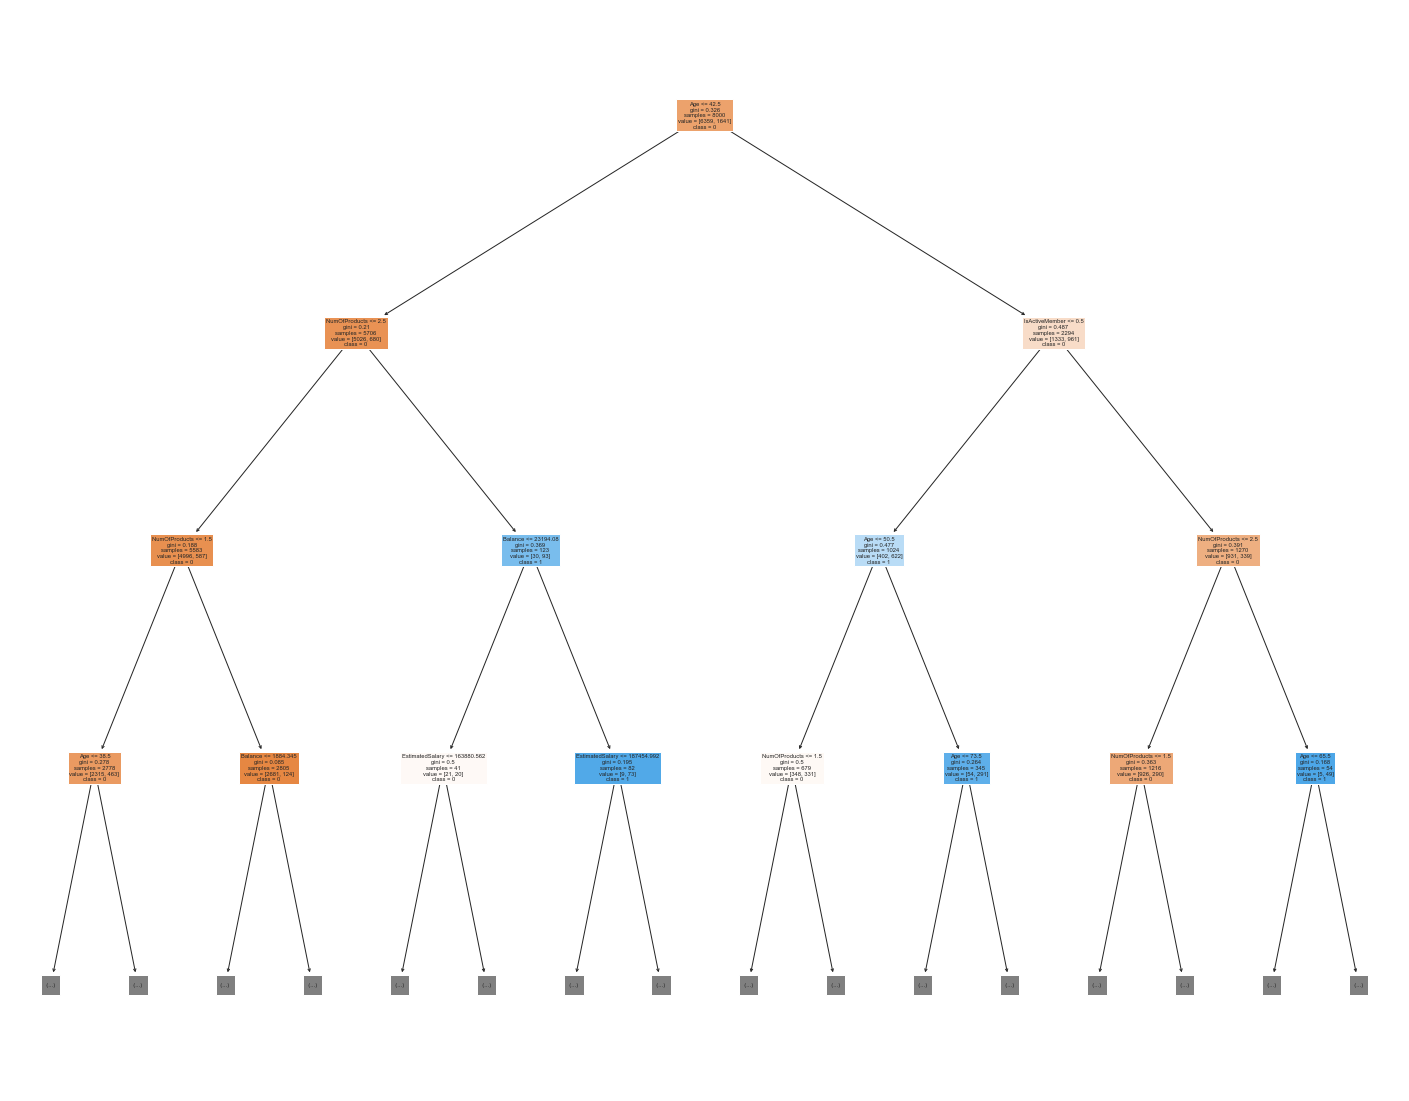

In [46]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

model = DecisionTreeClassifier()
model.fit(Xtrain , Ytrain)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(model, max_depth=3,feature_names=data.columns[:-1], class_names=['0','1'], filled=True)

<AxesSubplot:>

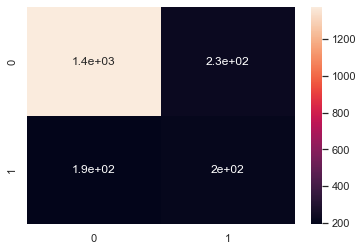

In [47]:
from sklearn.metrics import confusion_matrix 

predictions = model.predict(Xtest)
matrix = confusion_matrix(Ytest , predictions)
sns.heatmap(matrix,annot=True)

## Ensembles of Estimators: Random Forests

## 評估器合成：隨機森林

> that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*. each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a *random forest*. This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

多個過擬合的評估器可以被合併來減少過擬合，被稱為*裝袋(bagging)*，是一種團體學習。裝袋(bagging)將評估器組裝（類似塞到袋子裡）起來，其中的每個評估器都會產生過擬合，然後對結果求平均來得到一個更好的分類。對隨機決策樹的組裝被稱為*隨機森林*。這種類型的裝袋分類可以通過Scikit-Learn的`BaggingClassifier`元評估器來手動實現：

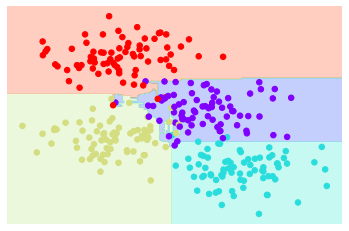

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

> In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

在上例中，我們通過在數據集的隨機80%的數據點上擬合出100個模型。在實踐中，決策樹可以通過注入更多的隨機性來選擇子數據集以達到更好的效果：這個方法中所有的數據在每次擬合過程中都會產生貢獻，但是擬合的結果仍然具有期望的隨機性。例如當決定哪個特徵來劃分數據集時，隨機決策樹可以從前面幾個特徵中進行不同的選擇。你可以在[Scikit-Learn在線文檔](http://scikit-learn.org/stable/modules/ensemble.html#forest)中督導更多這些隨機策略的技術細節。

> In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

在Scikit-Learn中，上述的隨機決策樹的優化組合算法被實現在`RandomForestClassifier`評估器中，它能全自動地處理所有的隨機情況。你只需要設置評估器的個數，它能迅速的（根據需要進行並行計算）擬合整個森林：可以看到，通過在100個隨機選擇的模型上進行平均，我們能夠得到一個更加符合我們對數據集分佈的直覺模型。

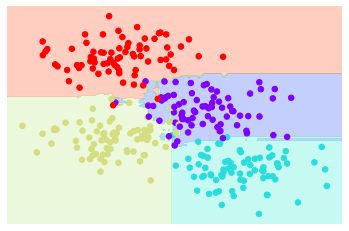

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

### Example RandomForests

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

data=pd.read_csv("input/Product.csv")
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


In [42]:
# GaussianNB 擬和 fit
from sklearn.preprocessing import StandardScaler

X=data.iloc[:,[2,3]].values
Y=data.iloc[:,4].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y,test_size=0.2)

model=RandomForestClassifier(max_leaf_nodes=10)
model.fit(X_train,Y_train)

RandomForestClassifier(max_leaf_nodes=10)

In [43]:
# 進行預測標籤
y_predicted=model.predict(X_test)
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0])

<AxesSubplot:>

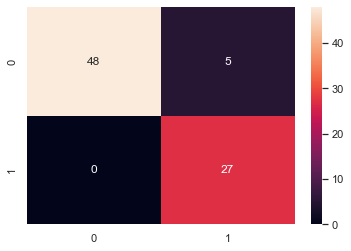

In [45]:
matrix=confusion_matrix(Y_test,y_predicted)
import seaborn as sns
sns.heatmap(matrix,annot=True)

## Random Forest Regression

## 隨機森林回歸

> In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

在前面內容中我們介紹了隨機森林應用在分類場景下的方法。隨機森林也能在回歸場景中使用（即非離散的分類而是連續的分類）。實現這個場景的評估器是`RandomForestRegressor`，它的語法和前面看到的分類語法很相似。

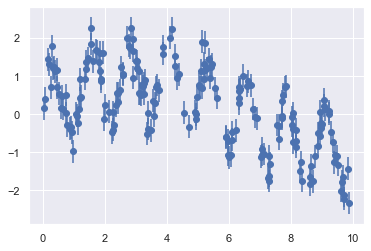

In [17]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

> Using the random forest regressor, we can find the best fit curve as follows:

使用隨機森林回歸，我們能獲得下面的最佳擬合曲線：

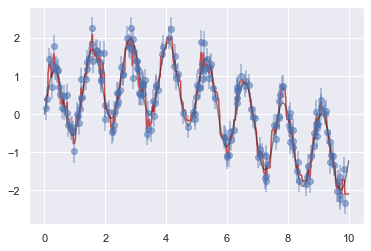

In [18]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

> Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

上面真實的數據使用灰色光滑的曲線展示，而隨機森林模型使用紅色鋸齒曲線展示。可以看到無參數的隨機森林模型可以足夠靈活的擬合多周期數據，甚至不需要指定任何多周期模型。

## Example: Random Forest for Classifying Digits

## 例子：使用隨機森林分類手寫數字

> Earlier we took a quick look at the hand-written digits data (see [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb)).
Let's use that again here to see how the random forest classifier can be used in this context.

前面我們快速的介紹了一下手寫數字數據（參見[Scikit-Learn簡介](05.02-Introducing-Scikit-Learn.ipynb)）。下面我們來看看隨機森林分類器在這個場景下的應用。

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

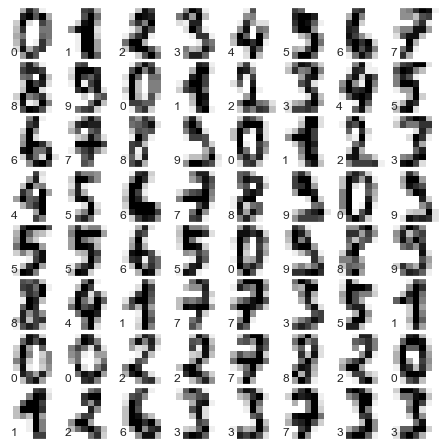

In [20]:
# 设置图表
fig = plt.figure(figsize=(6, 6))  # 图表尺寸
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 绘制数字，每个数字都是8x8大小
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # 添加数字的标签
    ax.text(0, 7, str(digits.target[i]))

> We can quickly classify the digits using a random forest as follows:

然後我們使用隨機森林來分類這些數字：

In [21]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [22]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



> And for good measure, plot the confusion matrix:

為了更清晰，還可以繪製混淆矩陣：

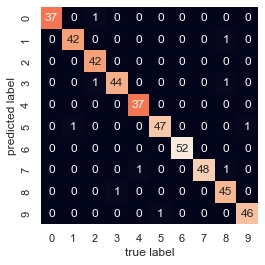

In [23]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

> We find that a simple, untuned random forest results in a very accurate classification of the digits data.

從這個例子我們發現，一個簡單未經過優化的隨機森林算法，就能在手寫數字分類上得到非常精確的分類結果。

## Summary of Random Forests

## 隨機森林總結

> This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

本節中介紹了*組合評估器*的概念，進一步介紹了隨機森林，一個隨機化決策樹的團隊算法。隨機森林由於下述優點使其成為很強大的一個方法：

- 訓練和預測都非常快，因為其基礎決策樹計算非常簡單。並且所有的任務都能直接地並行化，因為每一棵獨立的樹都是完全無關的。
- 多棵決策樹都可以進行概率分類：區域內的大多數票給出了概率分佈的估計值（使用Scikit-Learn的`predict_proba()`實現）。
- 無參數的模型非常靈活，可以在其他評估器欠擬合的情況下工作得很良好。

> A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

隨機森林最主要的缺點在於結果不容易解釋：也即是說，如果你試圖從分類模型中提取深層次的*含義*的話，隨機森林可能不是最好的選擇。

<!--NAVIGATION-->
< [深入：支持向量机](05.07-Support-Vector-Machines.ipynb) | [目录](Index.ipynb) | [深入：主成分分析](05.09-Principal-Component-Analysis.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.08-Random-Forests.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
